In [1]:
from matplotlib import pyplot as plt
import numpy as np
from classifier_utils import cnn_model, preprocess_img, reduce_palette, change_pixel_values, get_class
%matplotlib inline
import glob
import os
from skimage import io, img_as_float
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot #used for printing test
from keras import backend as K
from keras.utils.np_utils import to_categorical
import hashlib

Using TensorFlow backend.


# Loading CIFAR10 dataset

* -x_train: training set samples
* -y_train: training set labels

+ -x_test: test set samples
+ -y_test: test set labels

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train[0:50000] #bigger value
y_train = y_train[0:50000]

In [4]:
#set size of sample and number of classes
IMG_SIZE = 32 
NUM_CLASSES = 10
NUM_EXAMPLES = len(x_train)

###### Now let's reduce palette to 4 colours

In [5]:
X_fewer_colours = reduce_palette(x_train)

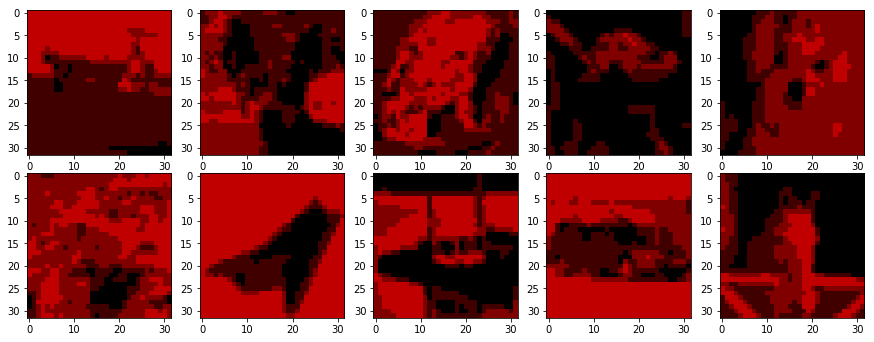

In [6]:
fig = plt.figure(figsize=(15,11))
fig.add_subplot(1,5,1)
plt.imshow(X_fewer_colours[2000])
a = fig.add_subplot(1,5,2)
plt.imshow(X_fewer_colours[2500])
fig.add_subplot(1,5,3)
plt.imshow(X_fewer_colours[3500])
fig.add_subplot(1,5,4)
plt.imshow(X_fewer_colours[5000])
fig.add_subplot(1,5,5)
plt.imshow(X_fewer_colours[5500])
fig.add_subplot(2,5,6)
plt.imshow(X_fewer_colours[6000])
fig.add_subplot(2,5,7)
plt.imshow(X_fewer_colours[7700])
fig.add_subplot(2,5,8)
plt.imshow(X_fewer_colours[8150])
fig.add_subplot(2,5,9)
plt.imshow(X_fewer_colours[8300])
fig.add_subplot(2,5,10)
plt.imshow(X_fewer_colours[4900])

###### Change colours to pseudo-random values. In a given image the same colour is mapped to the same pseudo-random value. (it takes a few minutes to process all pictures)

###### Now let's reduce palette to 4 colours

In [7]:
X_random_colours = np.zeros((NUM_EXAMPLES, IMG_SIZE, IMG_SIZE, 3),dtype='uint8')
for i in range(0,NUM_EXAMPLES):
    prefix = hashlib.sha256(X_fewer_colours[i]).hexdigest() #hash is calculated using all pixels in a given image
    X_random_colours[i] = change_pixel_values(IMG_SIZE, X_fewer_colours[i], prefix)

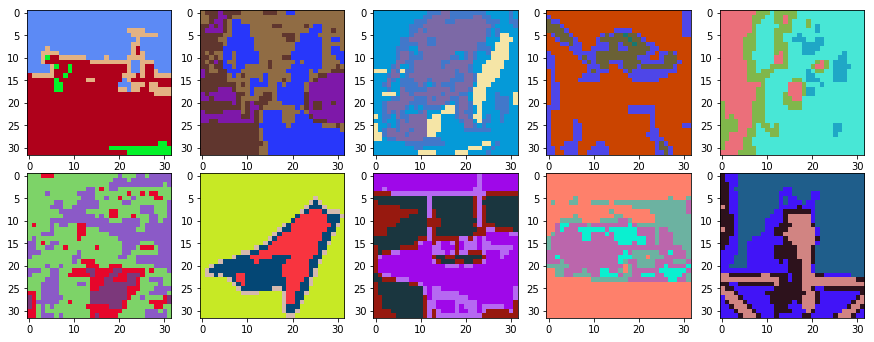

In [8]:
fig = plt.figure(figsize=(15,11))
fig.add_subplot(1,5,1)
plt.imshow(X_random_colours[2000])
a = fig.add_subplot(1,5,2)
plt.imshow(X_random_colours[2500])
fig.add_subplot(1,5,3)
plt.imshow(X_random_colours[3500])
fig.add_subplot(1,5,4)
plt.imshow(X_random_colours[5000])
fig.add_subplot(1,5,5)
plt.imshow(X_random_colours[5500])
fig.add_subplot(2,5,6)
plt.imshow(X_random_colours[6000])
fig.add_subplot(2,5,7)
plt.imshow(X_random_colours[7700])
fig.add_subplot(2,5,8)
plt.imshow(X_random_colours[8150])
fig.add_subplot(2,5,9)
plt.imshow(X_random_colours[8300])
fig.add_subplot(2,5,10)
plt.imshow(X_random_colours[4900])

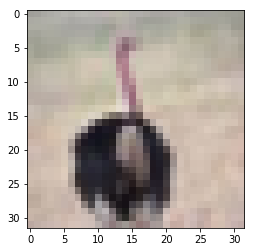

In [9]:
single_image = x_train[335:336]
plt.imshow(single_image[0]) 

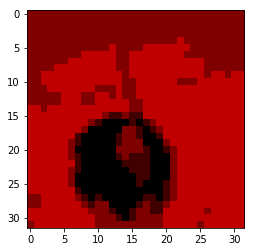

In [10]:
single_image = X_fewer_colours[335:336]
plt.imshow(single_image[0])         

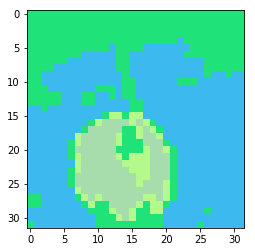

In [11]:
single_image = X_random_colours[335:336]
plt.imshow(single_image[0])

###### Change pixel values to float64 (between 0 and 1)

In [12]:
X_float = np.zeros((NUM_EXAMPLES, IMG_SIZE, IMG_SIZE, 3))
for i in xrange(0,NUM_EXAMPLES):
    X_float[i] = img_as_float(X_random_colours[i])

### Image resizing. 
Vgg16 takes minimum size of 48x48!

Pay attention on example below:
```python
x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0, preserve_range=True)
```
1. transform.resize changes values by default into range from -1 to 1.
2. To avoid mixing data types need to use: 
```python 
preserve_range=True
```

In [13]:
x_train = X_float

In [14]:
x_train_vgg = np.zeros((NUM_EXAMPLES,64,64,3))

for i in range(NUM_EXAMPLES):
    x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0, preserve_range=True) #need to preserve range for Float32

/usr/local/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
#set size of sample and number of classes
IMG_SIZE = 64 
NUM_CLASSES = 10

### Reducing amount of pictures

In [16]:
x_train_vgg = x_train_vgg[0:50000] #bigger value
y_train_vgg = y_train[0:50000]

In [17]:
x_train_vgg.shape

(50000, 64, 64, 3)

# Setting up model
Current example uses Vgg16 model. In case of this project there are only 10 categories so model need to be set with some changes on last layer. 
Last layer is removed with: 

```python 
include_top=False
```
then all layers are set to trainable and new Dense layer with 10 categories is added.

In [18]:
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMG_SIZE,IMG_SIZE,3), pooling=max)

58310656/58889256 [============================>.] - ETA: 0s

###### Add final layer and activation 

In [19]:
last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

# Training

In [20]:
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [21]:
model.compile(optimizer=Adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
#NO validation
model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=1) 
#with validation
#model.fit(training_set, training_labels, batch_size=128, epochs=1, validation_data=(validation_set, validation_labels))

Epoch 1/1
50000/50000 [==============================] - 310s - loss: 0.2970 - acc: 0.8967   


# Evaluation

In [27]:
X_test_fewer_colours = reduce_palette(x_test)

In [31]:
print X_test_fewer_colours.shape

(10000, 32, 32, 3)


In [34]:
x_test_vgg = np.zeros((len(X_test_fewer_colours),64,64,3))

for i in range(len(X_test_fewer_colours)):
    x_test_vgg[i] = transform.resize(X_test_fewer_colours[i], (64, 64), order=0, preserve_range=True) #need to preserve range for Float32

In [38]:
X_test_fewer_colours = x_test_vgg

In [39]:
X_test_random_colours = np.zeros((len(X_test_fewer_colours), 64, 64, 3),dtype='uint8')
for i in range(10000):
    prefix = hashlib.sha256(X_test_fewer_colours[i]).hexdigest() #hash is calculated using all pixels in a given image
    X_test_random_colours[i] = change_pixel_values(IMG_SIZE, X_test_fewer_colours[i], prefix)

In [41]:
X_test_float = np.zeros((10000, IMG_SIZE, IMG_SIZE, 3))
for i in xrange(10000):
    X_test_float[i] = img_as_float(X_test_random_colours[i])

In [42]:
model.evaluate(X_test_float, y_test, batch_size=32)

10000/10000 [==============================] - 23s    


[1.3408168709754944, 0.6401]